# Importing Libraries and predictions

In [1]:
import os
os.chdir("../../")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
from utilities import plot,errors,recalibration
from datetime import datetime

import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [3]:
from probml_utils import latexify,savefig

In [4]:
%env LATEXIFY=1
%env FIG_DIR=figures/

env: LATEXIFY=1
env: FIG_DIR=figures/


In [5]:
os.chdir('notebooks/microwave')

In [6]:
s2p_mlp_training = pd.read_csv('s2p/mlp/training_predictions.csv')
s2p_mlp_testing = pd.read_csv('s2p/mlp/testing_predictions.csv')
s2p_gmlp_training = pd.read_csv('s2p/gmlp/training_predictions.csv')
s2p_gmlp_testing = pd.read_csv('s2p/gmlp/testing_predictions.csv')

In [7]:
lstm_mlp_training = pd.read_csv('lstm/mlp/training_predictions.csv')
lstm_mlp_testing = pd.read_csv('lstm/mlp/testing_predictions.csv')
lstm_gmlp_training = pd.read_csv('lstm/gmlp/training_predictions.csv')
lstm_gmlp_testing = pd.read_csv('lstm/gmlp/testing_predictions.csv')

In [8]:
s2p_mlp_recal = pd.read_csv('s2p/mlp/recalibration_df.csv')
s2p_gmlp_recal = pd.read_csv('s2p/gmlp/recalibration_df.csv')
lstm_mlp_recal=pd.read_csv('lstm/mlp/recalibration_df.csv')
lstm_gmlp_recal=pd.read_csv('lstm/gmlp/recalibration_df.csv')

In [9]:
s2p_mlp_training.columns = map(str.lower, s2p_mlp_training.columns)
s2p_mlp_testing.columns = map(str.lower, s2p_mlp_testing.columns)
s2p_gmlp_training.columns = map(str.lower, s2p_gmlp_training.columns)
s2p_gmlp_testing.columns = map(str.lower, s2p_gmlp_testing.columns)

In [10]:
lstm_mlp_training.columns = map(str.lower, lstm_mlp_training.columns)
lstm_mlp_testing.columns = map(str.lower, lstm_mlp_testing.columns)
lstm_gmlp_training.columns = map(str.lower, lstm_gmlp_training.columns)
lstm_gmlp_testing.columns = map(str.lower, lstm_gmlp_testing.columns)

In [11]:
os.chdir("../../")

# Define Functions

In [12]:

def rmse_(dataframe):
    def rmse_loss(y,yhat):
      return (y-yhat)**2
    return jnp.mean(jax.vmap(rmse_loss,in_axes=(0,0))(dataframe['Ideal'].values,dataframe['Counts'].values))
def mae_(dataframe):
    def mae(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(mae,in_axes=(0,0))(dataframe['p'].values,dataframe['p_hat'].values))
def mae1(y,yhat):
    def mae(y,yhat):
      return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(mae,in_axes=(0,0))(y,yhat))
def NLL(mean,sigma,y):
    def loss_fn(mean, sigma, y):
      d = dist.Normal(loc=mean, scale=sigma)
      return -d.log_prob(y)
    return jnp.mean(jax.vmap(loss_fn, in_axes=(0, 0, 0))(mean, sigma, y))

def plot_predictions(y_true,mean,sigma):
    idx1 = 0
    idx2 = -1
    fig, ax = plt.subplots(2, 2, figsize=(18,10))
    ax = ax.ravel()
    ax[0].plot(y_true[idx1:idx2], label="True")
    ax[1].plot(mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
    ax[2].plot(y_true[idx1:idx2], label="True")
    ax[2].plot(mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
    #ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
    ax[3].plot(sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
    ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
    sns.despine()


In [13]:
import scipy.stats as st
def calibrate(mean, sigma, Y):
    df = pd.DataFrame()
    df["mean"] = mean
    df["sigma"] = sigma
    df["Y"] = Y
    df["z"] = (df["Y"] - df["mean"]) / df["sigma"]
    df["perc"] = st.norm.cdf(df["z"])
    k = jnp.arange(0, 1.1, 0.1)
    counts = []
    df2 = pd.DataFrame()
    df2["Interval"] = k
    df2["Ideal"] = k
    for i in range(0, 11):
        l = df[df["perc"] < 0.5 + i * 0.05]
        l = l[l["perc"] >= 0.5 - i * 0.05]
        counts.append(len(l) / len(df))
    df2["Counts"] = counts
    return df2

In [14]:
def calculate_errors(tr_df, te_df, recal_df):
    for i,j in zip(grp, grp2):
        try:
            q = tr_df[i+'sigma']
            tr_nll.append(errors.NLL(tr_df[i+'mean'].values,tr_df[i+'sigma'].values,tr_df['ground truth'].values))
            te_nll.append(errors.NLL(te_df[i+'mean'].values,te_df[i+'sigma'].values,te_df['ground truth'].values))
            df =  recalibration.find_p_hat(tr_df['ground truth'].values,tr_df[i+'mean'].values,tr_df[i+'sigma'].values) 
            df=df.reset_index()
            tr_ce.append(mae_(df))
            df1 =  recalibration.find_p_hat(te_df['ground truth'].values,te_df[i+'mean'].values,te_df[i+'sigma'].values) 
            df1=df1.reset_index()
            te_ce.append(mae_(df1))
            te_rce.append(mae1(recal_df['p'].values,recal_df['new_phat'+j].values))
            
        except KeyError:
            # print(KeyError.args)
            tr_nll.append(0)
            te_nll.append(0)
            tr_ce.append(0)
            # tr_l2_ce.append(0)
            te_ce.append(0)
            te_rce.append(0)
            # te_l2_ce.append(0)
            # pass
            

def calculate_rmse(tr_df,te_df):
    for i in grp:
        tr_rmse.append((errors.rmse(tr_df['ground truth'].values,tr_df[i+'mean'].values)))
        te_rmse.append((errors.rmse(te_df['ground truth'].values,te_df[i+'mean'].values)))
        tr_mae.append((errors.mae(tr_df['ground truth'].values,tr_df[i+'mean'].values)))
        te_mae.append((errors.mae(te_df['ground truth'].values,te_df[i+'mean'].values)))


# Table

In [15]:
metric  =pd.DataFrame({'approach':[],'Tr_mae':[],'Te_mae':[],'Tr_rmse':[],'Te_rmse':[],'Tr_nll':[],'Te_nll':[],
'Tr_ce':[],'Te_ce':[],'Te_rce':[]})
row1 = {'approach':['s2p','s2p+mc','s2p+de','s2p+bs','gs2p','gs2p+mc','gs2p+de','gs2p+bs',
'lstm','lstm+mc','lstm+de','lstm+bs','glstm','glstm+mc','glstm+de','glstm+bs']}
grp = ['','mc_','de_','bs_']
grp2 = ['','_mc','_de','_bs']
tr_rmse,te_rmse = [],[]
tr_mae,te_mae = [],[]
tr_nll,te_nll = [],[]
tr_ce,te_ce,te_rce = [],[],[]
row1 = pd.DataFrame(row1)
metric = pd.concat([metric,row1],ignore_index=True)


In [16]:
calculate_rmse(s2p_mlp_training,s2p_mlp_testing)
calculate_rmse(s2p_gmlp_training,s2p_gmlp_testing)
calculate_rmse(lstm_mlp_training,lstm_mlp_testing)
calculate_rmse(lstm_gmlp_training,lstm_gmlp_testing)
calculate_errors(s2p_mlp_training,s2p_mlp_testing,s2p_mlp_recal)
calculate_errors(s2p_gmlp_training,s2p_gmlp_testing,s2p_gmlp_recal)
calculate_errors(lstm_mlp_training,lstm_mlp_testing,lstm_mlp_recal)
calculate_errors(lstm_gmlp_training,lstm_gmlp_testing,lstm_gmlp_recal)
metric['Tr_rmse']=tr_rmse
metric['Te_rmse']=te_rmse
metric['Tr_mae']=tr_mae
metric['Te_mae']=te_mae
metric['Tr_nll']=tr_nll
metric['Te_nll']=te_nll
metric['Tr_ce']=tr_ce
metric['Te_ce']=te_ce	
metric['Te_rce']=te_rce	
	

In [17]:
metric

,approach,Tr_mae,Te_mae,Tr_rmse,Te_rmse,Tr_nll,Te_nll,Tr_ce,Te_ce,Te_rce
0,s2p,2.6634378,11.185808,21.998465,79.72997,0,0,0,0,0
1,s2p+mc,2.728726,11.174248,21.450102,79.869736,6002372000000.0,611580000000000.0,0.4707669,0.4779978,0.45367864
2,s2p+de,2.1759636,11.16834,14.281735,78.379105,14.269382,1716.842,0.39734286,0.43984994,0.35460818
3,s2p+bs,2.9391656,11.254164,24.874496,77.65649,2.0234873,151.13048,0.17084645,0.30711654,0.17777275
4,gs2p,7.6596737,12.463739,88.40875,101.65248,1.4506961,95.31384,0.06553617,0.030832961,0.07791727
5,gs2p+mc,7.4150567,12.560314,88.67215,101.86559,1.2347395,135.65884,0.13754135,0.08390924,0.18627793
6,gs2p+de,14.125846,12.524833,89.10583,101.0336,2.3728287,35.2812,0.15533061,0.1393589,0.07405773
7,gs2p+bs,8.017901,13.274323,88.26325,101.55706,2.9592628,6.9476523,0.38589036,0.15928474,0.35608548
8,lstm,7.3846245,16.769403,43.665623,88.36018,0,0,0,0,0
9,lstm+mc,7.420004,16.7785,43.671787,88.369156,121.93306,2197.4915,0.27544808,0.4374076,0.2570262


# Analysis

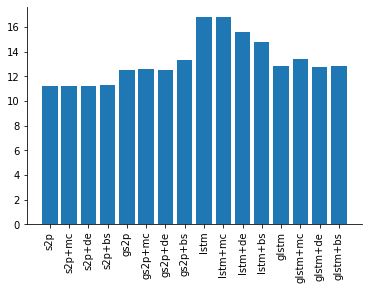

In [18]:
plt.bar(metric['approach'],metric['Te_mae'])
# plt.bar(metric['approach'],metric['Te_l1_ce'])
plt.xticks(rotation=90)
sns.despine()

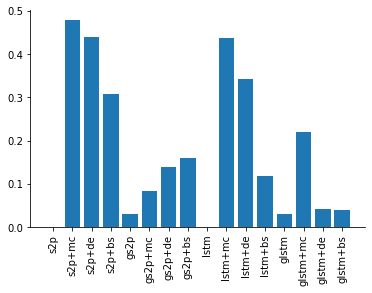

In [19]:
plt.bar(metric['approach'],metric['Te_ce'])
plt.xticks(rotation=90)
sns.despine()

MAE = s2p_mlp_testing de \
TRADEOFF = lstm_mlp_testing bs \
ECE = s2p_gmlp_testing simple 

In [20]:
idx1=2675
idx2=2750

In [21]:
timestamp = s2p_gmlp_testing["timestamp"][idx1:idx2]

In [22]:
timestamp = pd.to_datetime(timestamp).dt.strftime('%H:%M')

In [23]:
def plot_figure(ax, y, mean, sigma, title):
    ax.plot(timestamp, y[idx1:idx2], label="Y")
    ax.plot(timestamp, mean[idx1:idx2], label="Mean")
    ax.plot(timestamp, sigma[idx1:idx2], label="Sigma")
    ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)
    ax.tick_params(axis='x',rotation=60)
    error = errors.mae(y.values, mean.values)
    df = recalibration.find_p_hat(y, mean, sigma)
    df=df.reset_index()
    ax.set_title(f'{title} \nMAE = {error:.2f}, ECE = {mae_(df):.2f}\n')


In [24]:
def plot_callibration(ax, y, mean, sigma):
    off_idx = y <= 200
    on_idx = y > 200
    off_truth, off_mean, off_sigma = y[off_idx], mean[off_idx], sigma[off_idx]
    on_truth, on_mean, on_sigma = y[on_idx], mean[on_idx], sigma[on_idx]

    df = recalibration.find_p_hat(y, mean, sigma)
    df=df.reset_index()
    ax.plot(df["p"], df["p_hat"], "--", label="Total")
    total_error = mae_(df)

    df = recalibration.find_p_hat(off_truth,  off_mean, off_sigma)
    df=df.reset_index()
    ax.plot(df["p"], df["p_hat"], "--", label="Off")
    off_error = mae_(df)

    df = recalibration.find_p_hat(on_truth,  on_mean, on_sigma)
    df=df.reset_index()
    ax.plot(df["p"], df["p_hat"], "--", label="On")
    on_error = mae_(df)

    ax.plot([0,1],[0,1], "--", color="black", label="Ideal")
    ax.set_title(f'\nOn ECE = {on_error:.4f}\nOff ECE = {off_error:.4f}')

In [25]:
latexify(fig_width=6.6,fig_height=4)

/tmp/ipykernel_1023/1669252933.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)
/tmp/ipykernel_1023/1669252933.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)
/tmp/ipykernel_1023/1669252933.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks(jnp.arange(0, idx2-idx1, 30), fontsize=2)


saving image to figures/best_error_microwave_latexified.pdf


/home/rohit_khoiwal/anaconda3/lib/python3.9/site-packages/probml_utils/plotting.py:93: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(pad=pad_inches)


Figure size: [6.6 4. ]


<Figure size 475.2x288 with 0 Axes>

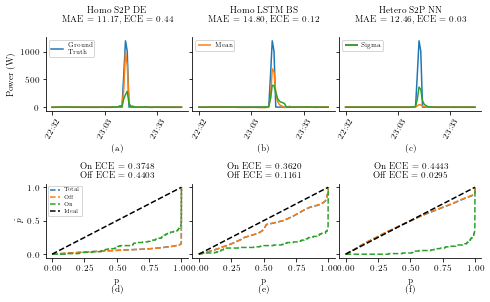

In [26]:
plt.figure()
fig, ax = plt.subplots(2, 3, sharey="row", constrained_layout = True)

plot_figure(ax[0,0], s2p_mlp_testing["ground truth"], s2p_mlp_testing["de_mean"], 
            s2p_mlp_testing["de_sigma"], "Homo S2P DE")
plot_figure(ax[0,1], lstm_mlp_testing["ground truth"], lstm_mlp_testing["bs_mean"], 
            lstm_mlp_testing["bs_sigma"], "Homo LSTM BS")
plot_figure(ax[0,2], s2p_gmlp_testing["ground truth"], s2p_gmlp_testing["mean"], 
            s2p_gmlp_testing["sigma"], "Hetero S2P NN")

plot_callibration(ax[1,0], s2p_mlp_testing["ground truth"], s2p_mlp_testing["de_mean"], 
                  s2p_mlp_testing["de_sigma"])
plot_callibration(ax[1,1], lstm_mlp_testing["ground truth"], lstm_mlp_testing["bs_mean"], 
                  lstm_mlp_testing["bs_sigma"])
plot_callibration(ax[1,2], s2p_gmlp_testing["ground truth"], s2p_gmlp_testing["mean"], 
                  s2p_gmlp_testing["sigma"])
ax[0,0].legend(["Ground\nTruth"], loc="upper left", fontsize=6)
line = mlines.Line2D([], [], color='C1', marker="_", ls='', label='Mean', markersize=13,
                    markeredgewidth=1.5)
ax[0,1].legend(handles=[line], loc="upper left", fontsize=6)
line = mlines.Line2D([], [], color='green', marker="_", ls='', label='Sigma', markersize=13,
                    markeredgewidth=1.5)
ax[0,2].legend(handles=[line], loc="upper left", fontsize=6)

ax[0,0].set_xlabel("(a)")
ax[0,1].set_xlabel("(b)")
ax[0,2].set_xlabel("(c)")
ax[1,0].set_xlabel("p\n(d)")
ax[1,1].set_xlabel("p\n(e)")
ax[1,2].set_xlabel("p\n(f)")

ax[1,0].legend(fontsize=5, loc="upper left")
ax[0,0].set_ylabel("Power (W)")
ax[1,0].set_ylabel("$\hat{p}$")
sns.despine()
savefig("best_error_microwave")